In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
import cv2

In [2]:
image_file = '/home/golden/Desktop/radon_image.jpeg'
image = cv2.imread(image_file)
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_gray = image_gray / image_gray.max()
image_gray = rescale(image_gray, scale=0.4, mode='reflect', multichannel=False)
print(image_gray.shape)
print(image_gray.max())

(68, 68)
0.95931372549


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
r_image = radon(image_gray, circle=True)
r_image_scaled = r_image
print(r_image.min())
print(r_image.max())
print(r_image.shape)

0.0
22.8591297519
(68, 180)


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


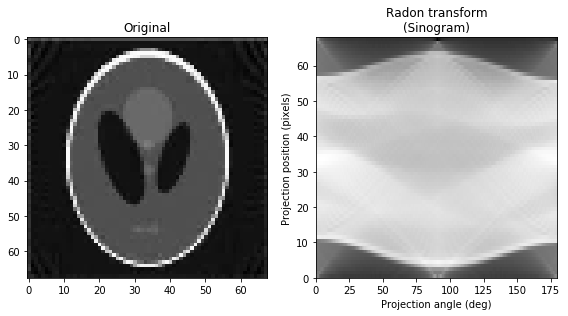

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image_gray, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image_gray, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(r_image, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
fig.tight_layout()
plt.show()

out_image shape (2, 2160, 2160)
phase cor (-139.50319243829927, 0.03030685177009218) -139.50319243829927
-11.625266036524938


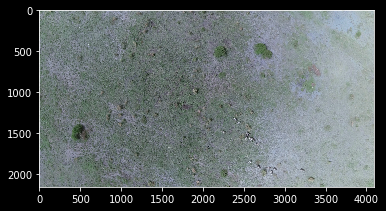

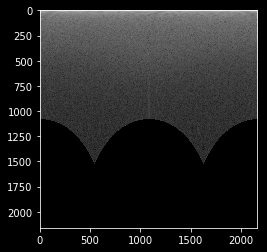

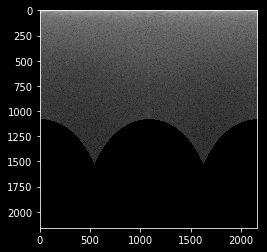

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
import cv2
import glob
import math

from PIL import Image

plt.style.use('dark_background')

image_folder_file = '/media/golden/72FFC6EE48B5CF39/kenya-tracking/raw_frames/scare_clips/PZ/test_rotation'
image_files = glob.glob(image_folder_file + '/*.jpg')

# test_image_file = '/home/golden/Desktop/2d_sine_wave.jpeg'

raw_image_one = cv2.imread(image_files[10]) / 255
raw_image_two = cv2.imread(image_files[15]) / 255

# raw_image_one = cv2.imread(test_image_file) / 255
# raw_image_two = cv2.imread(test_image_file) / 255

plt.imshow(raw_image_one)
plt.figure()

image_shape = raw_image_one.shape

circle_mask = np.zeros((image_shape[0], image_shape[0]))
circle_mask = cv2.circle(
    circle_mask, (int(image_shape[0]/2), int(image_shape[0]/2)), int(image_shape[0]/2), (1), -1)

plt.gray()

sess = tf.InteractiveSession()

#load image as tensor
image_tensor_one = tf.constant(raw_image_one)
image_tensor_one = tf.image.rgb_to_grayscale(image_tensor_one)

image_tensor_two = tf.constant(raw_image_two)
image_tensor_two = tf.image.rgb_to_grayscale(image_tensor_two)

image_tensor = tf.stack([image_tensor_one, image_tensor_two])

#get length of x that has to be cropped to get the center square of image
image_shape = tf.shape(image_tensor)
scale = (image_shape[2] - image_shape[1]) / image_shape[2]
x_crop = (scale) / 2


crop_box = tf.stack([0.0, x_crop, 1.0, 1.0-x_crop]) 
crop_box = tf.cast(crop_box, dtype=tf.float32)
crop_box = tf.expand_dims(crop_box, 0)
crop_box = tf.tile(crop_box, [image_shape[0], 1])

image_crop = tf.image.crop_and_resize(
    image_tensor, crop_box, tf.range(image_shape[0]), [image_shape[1], image_shape[1]])
image_crop = tf.squeeze(image_crop)

# im = sess.run(image_crop)
# plt.imshow(im[0])
# plt.figure()


#apply circle mask 
circle_mask = tf.constant(circle_mask, dtype=tf.float32)
circle_mask = tf.expand_dims(circle_mask, 0)
circle_mask = tf.tile(circle_mask, [image_shape[0], 1, 1])
image_crop = tf.where(tf.cast(circle_mask, tf.bool), image_crop, circle_mask)

# sine_image = sess.run(image_crop)
# sine_fft = np.fft.fftshift(np.fft.fft2(sine_image[0]))
# sine_fft_mag = np.abs(sine_fft)
# sine_fft_mag = np.log(sine_fft_mag + 1)

# plt.title('np fft')
# plt.imshow(sine_fft_mag / sine_fft_mag.max())
# plt.figure()


image_crop_complex = tf.cast(image_crop, tf.complex64)
image_fft = tf.fft2d(image_crop_complex)


def fftshift(fft_image):
    #must be square
    shape = tf.shape(fft_image)
    quad_one = tf.slice(
        fft_image, [0, 0, tf.floordiv(shape[2]+1, 2)], [-1, tf.floordiv(shape[1]+1, 2), -1])
    quad_two = tf.slice(
        fft_image, [0, 0, 0], [-1, tf.floordiv(shape[1]+1, 2), tf.floordiv(shape[2]+1, 2)])
    quad_three = tf.slice(
        fft_image, [0, tf.floordiv(shape[1]+1, 2), 0], [-1, -1, tf.floordiv(shape[2]+1, 2)])
    quad_four = tf.slice(
        fft_image, [0, tf.floordiv(shape[1]+1, 2), tf.floordiv(shape[2]+1, 2)], [-1, -1, -1])
    
    new_top = tf.concat([quad_four, quad_three], 2)
    new_bottom = tf.concat([quad_one, quad_two], 2)
    
    shifted_fft = tf.concat([new_top, new_bottom], 1)
    
    return shifted_fft

image_fft_shift = fftshift(image_fft)

#skipped mid frequency notch filter



image_fft_mag = tf.abs(image_fft_shift)

def to_polar(image):
    shape = tf.shape(image)

    theta = tf.linspace(0.0, math.pi, shape[2])
    theta = tf.expand_dims(theta, 0)
    theta = tf.tile(theta, (shape[1], 1))

    radius_x = tf.cast(tf.range(0, shape[1]), dtype=tf.float32)
    radius_x = tf.expand_dims(radius_x, 1)
    radius_x = tf.tile(radius_x, (1, shape[2]))

    # get copy of tensor
    radius_y = radius_x * 1.0 
    
    float_shape = tf.cast(shape[1], dtype=tf.float32)
    
    y = radius_y * tf.sin(theta) + float_shape / tf.constant(2.0)
    x = radius_x * tf.cos(theta) + float_shape / tf.constant(2.0)
    
    y_flat = tf.reshape(y, [1, -1])
    x_flat = tf.reshape(x, [1, -1])
    
    y_flat_batch = tf.tile(y_flat, [shape[0], 1])
    x_flat_batch = tf.tile(x_flat, [shape[0], 1])
    
    
    polar_coords = tf.stack([y_flat_batch, x_flat_batch], 2)
    
    image = tf.expand_dims(image, 3)
    
    
    polar_flat = tf.contrib.resampler.resampler(image, polar_coords)
    polar_image = tf.reshape(polar_flat, [shape[0], shape[1], shape[1]])
    return(polar_image)
    
image_polar = to_polar(image_fft_mag) 

def phase_correlation(images):
    images = tf.cast(images, tf.complex64)
    fft_images = tf.fft2d(images)
    ims0 = images[::2,:,:]
    ims1 = images[1::2,:,:]
    phase_shift_numerator = (ims0 * tf.conj(ims1))
    phase_shift_denominator = tf.abs(ims0) * tf.abs(ims1) + tf.constant(1e-10, dtype=tf.float32) 
    phase_shift_denominator = tf.cast(phase_shift_denominator, tf.complex64)
    c_phase_shift = tf.ifft2d(phase_shift_numerator/phase_shift_denominator)
    c_phse_shift = tf.abs(c_phase_shift) 
    return fftshift(c_phase_shift)

image_final = tf.abs(phase_correlation(image_polar))



#based on _get_angle_scale from imreg_dft

#skipping aprodization.  add if giving bad results




# out_image = sess.run(image_crop)
# print(out_image.shape)

# plt.imshow(out_image[0])


# plt.figure()
# out_image = sess.run(image_fft)
# print(out_image.shape)


# out_image = sess.run(image_fft_mag)
# print(out_image.shape)

# plt.figure()
# display_image = np.log(out_image[0] + 1) 
# plt.imshow(display_image / display_image.max())

# plt.figure()
# display_image = np.log(out_image[1] + 1) 
# plt.imshow(display_image / display_image.max())

out_image = sess.run(image_polar)
plt.figure()
display_image = np.log(out_image[0] + 1) 
plt.imshow(display_image / display_image.max())

plt.figure()
display_image = np.log(out_image[1] + 1) 
plt.imshow(display_image / display_image.max())

phase_cor, _ =  cv2.phaseCorrelate(out_image[0], out_image[1])
print('out_image shape', out_image.shape)
print('phase cor', phase_cor, phase_cor[0])
angle = np.pi / out_image.shape[1] * phase_cor[0] * 180.0 / np.pi
print(angle)

# out_image = sess.run(image_final)
# plt.figure()
# print('lastim', out_image.shape)
# display_image = np.log(out_image[0] + 1) 
# plt.imshow(display_image / display_image.max())

sess.close()

In [9]:
import scipy.ndimage as image


new_im = image.interpolation.rotate(raw_image_two, -angle, reshape=False)
# trans = cv2.phaseCorrelate(raw_image_one[:,:,1], new_im[:,:,1])
# new_im = image.interpolation.shift(new_im, [-trans[0][1], trans[0][0], 0])
# print(trans)

new_im = new_im - new_im.min()
new_im = new_im / new_im.max()

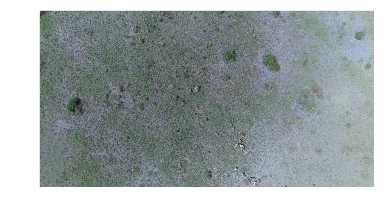

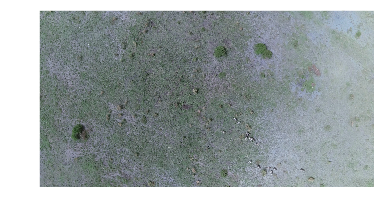

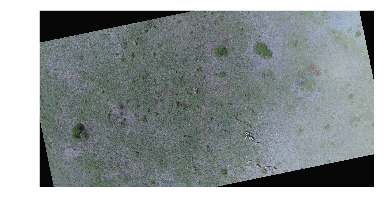

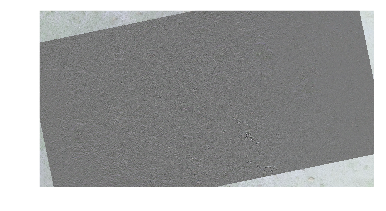

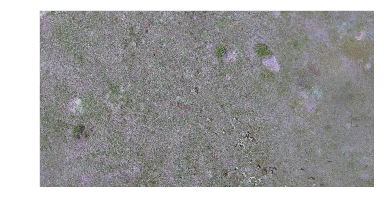

In [10]:
plt.figure()
plt.imshow(raw_image_two)

plt.figure()
plt.imshow(raw_image_one)

plt.figure()
plt.imshow(new_im)

plt.figure()
dif = raw_image_one - new_im 
dif = (dif - dif.min())
plt.imshow(dif/dif.max())

plt.figure()
dif = raw_image_one - raw_image_two 
dif = (dif - dif.min())
plt.imshow(dif/dif.max())

In [21]:
ret = (int(max(x)), ) * 2

In [54]:
sess = tf.InteractiveSession()
test_im = tf.range(9, dtype=tf.float32)
test_im = tf.reshape(test_im, (3, 3))
print(sess.run(test_im))
test_im = tf.reshape(test_im, (1, 3, 3, 1))
print(sess.run(tf.argmax(test_im, axis=0)))


[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]
[[[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]]


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [60]:
get = tf.constant((1.3,2), dtype=tf.float32)
get = tf.expand_dims(get, 0)
out_im = tf.contrib.resampler.resampler(test_im, get)

In [61]:
sess.run(out_im)

array([[ 7.30000019]], dtype=float32)

In [30]:
x = tf.ones(10)
x = tf.reshape(x, [-1])
y = tf.zeros(10)
y = tf.reshape(y, [-1])
z = tf.stack([x, y], axis=1)

In [31]:
sess.run(tf.shape(z))

array([10,  2], dtype=int32)

In [48]:
x = tf.ones((4,3,3))

In [50]:
v = x[0::2,:,:]
print(sess.run(v))

[[[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]
